In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules

### Step 0: Load Preprocessed Binary Encoded Dataset

In [2]:
# Replace with the actual path to your CSV
df = pd.read_csv(r"data/processed_data.csv")

# Ensure all values are boolean / binary
df = df.astype(bool)

print("Dataset shape:", df.shape)
print("Sample transactions:")
df.head()

Dataset shape: (500, 71)
Sample transactions:


,Age_Teen,Age_Young_Adult,Age_Adult,Age_Mid_Adult,Location_India,Location_US,Location_Other,Gender_Female,Gender_Male,Gender_Other,...,Spend_100-500,Spend_500-1000,Spend_1000plus,Spend_Unknown,Reason_Fun,Reason_Stress_Relief,Reason_Skills_Competition,Reason_Socialize,Reason_Learning,Reason_Other
0,True,False,False,False,True,False,False,False,True,False,...,False,False,False,False,True,True,False,False,False,False
1,False,True,False,False,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
2,False,True,False,False,True,False,False,False,True,False,...,True,False,False,False,True,False,False,False,False,False
3,True,False,False,False,False,False,True,True,False,False,...,False,False,False,False,True,False,False,False,False,False
4,True,False,False,False,True,False,False,True,False,False,...,False,False,False,False,True,True,True,True,False,False


### Step 1: Generate Frequent Itemsets

In [3]:
MIN_SUPPORT = 0.25  # adjust based on dataset size (500+ entries recommended)

frequent_itemsets = apriori(
    df,
    min_support=MIN_SUPPORT,
    use_colnames=True
)

frequent_itemsets.sort_values(by="support", ascending=False, inplace=True)

print("\nFrequent Itemsets:")
print(frequent_itemsets)


Frequent Itemsets:
    support                                        itemsets
26    0.668                                    (Reason_Fun)
13    0.596                        (Genre_Action/Adventure)
11    0.588                                 (Device_Mobile)
4     0.536                                 (Gender_Female)
2     0.530                                (Location_India)
..      ...                                             ...
25    0.252                                 (Spend_100-500)
53    0.252           (Reason_Fun, Gaming_Hours_5-10_hours)
59    0.250        (Device_Mobile, Discovery_Gaming_Forums)
80    0.250  (Discovery_Social_Media, Reason_Stress_Relief)
85    0.250                       (Spend_lt100, Reason_Fun)

[88 rows x 2 columns]


### Step 2: Generate Association Rules

In [4]:
MIN_CONFIDENCE = 0.5

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=MIN_CONFIDENCE
)

In [5]:
rules = rules.reset_index(drop=True)

In [6]:
lift_filter = (rules["lift"] > 1)

In [7]:
confidence_filter = (rules["confidence"] >= MIN_CONFIDENCE)

In [8]:
filter_values = pd.DataFrame({
    "lift_filter": lift_filter,
    "confidence_filter": confidence_filter
})

filter_values

,lift_filter,confidence_filter
0,True,True
1,True,True
2,False,True
3,False,True
4,True,True
...,...,...
81,False,True
82,True,True
83,True,True
84,True,True


In [13]:
# Optional: filter for meaningful rules
rules = rules[
    lift_filter & confidence_filter
]

rules

C:\Users\Admin\AppData\Local\Temp\ipykernel_14936\5943127.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rules = rules[


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Reason_Fun),(Device_Mobile),0.668,0.588,0.400,0.598802,1.018371,1.0,0.007216,1.026925,0.054337,0.467290,0.026219,0.639537
1,(Device_Mobile),(Reason_Fun),0.588,0.668,0.400,0.680272,1.018371,1.0,0.007216,1.038383,0.043786,0.467290,0.036964,0.639537
4,(Reason_Fun),(Game_Mode_Both),0.668,0.526,0.380,0.568862,1.081487,1.0,0.028632,1.099417,0.226950,0.466830,0.090427,0.645648
5,(Game_Mode_Both),(Reason_Fun),0.526,0.668,0.380,0.722433,1.081487,1.0,0.028632,1.196110,0.158961,0.466830,0.163956,0.645648
8,(Genre_Action/Adventure),(Device_Mobile),0.596,0.588,0.356,0.597315,1.015843,1.0,0.005552,1.023133,0.038603,0.429952,0.022610,0.601379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,(Reason_Skills_Competition),(Device_Mobile),0.430,0.588,0.258,0.600000,1.020408,1.0,0.005160,1.030000,0.035088,0.339474,0.029126,0.519388
82,(Gender_Male),(Discovery_Social_Media),0.464,0.526,0.254,0.547414,1.040711,1.0,0.009936,1.047314,0.072982,0.345109,0.045177,0.515152
83,(Gaming_Hours_5-10_hours),(Reason_Fun),0.322,0.668,0.252,0.782609,1.171570,1.0,0.036904,1.527200,0.215995,0.341463,0.345207,0.579927
84,(Discovery_Gaming_Forums),(Device_Mobile),0.396,0.588,0.250,0.631313,1.073662,1.0,0.017152,1.117479,0.113589,0.340599,0.105129,0.528242


In [10]:
print("\nAssociation Rules:")
print(
    rules[
        ["antecedents", "consequents", "support", "confidence", "lift"]
    ].head(15)
)


Association Rules:
                 antecedents               consequents  support  confidence  \
0               (Reason_Fun)           (Device_Mobile)    0.400    0.598802   
1            (Device_Mobile)              (Reason_Fun)    0.400    0.680272   
4               (Reason_Fun)          (Game_Mode_Both)    0.380    0.568862   
5           (Game_Mode_Both)              (Reason_Fun)    0.380    0.722433   
8   (Genre_Action/Adventure)           (Device_Mobile)    0.356    0.597315   
9            (Device_Mobile)  (Genre_Action/Adventure)    0.356    0.605442   
14           (Gender_Female)  (Genre_Action/Adventure)    0.334    0.623134   
15  (Genre_Action/Adventure)           (Gender_Female)    0.334    0.560403   
16               (Genre_FPS)              (Reason_Fun)    0.330    0.693277   
18  (Genre_Action/Adventure)          (Game_Mode_Both)    0.322    0.540268   
19          (Game_Mode_Both)  (Genre_Action/Adventure)    0.322    0.612167   
20          (Game_Mode_Both)    

### Step 3: Visualize Association Rules

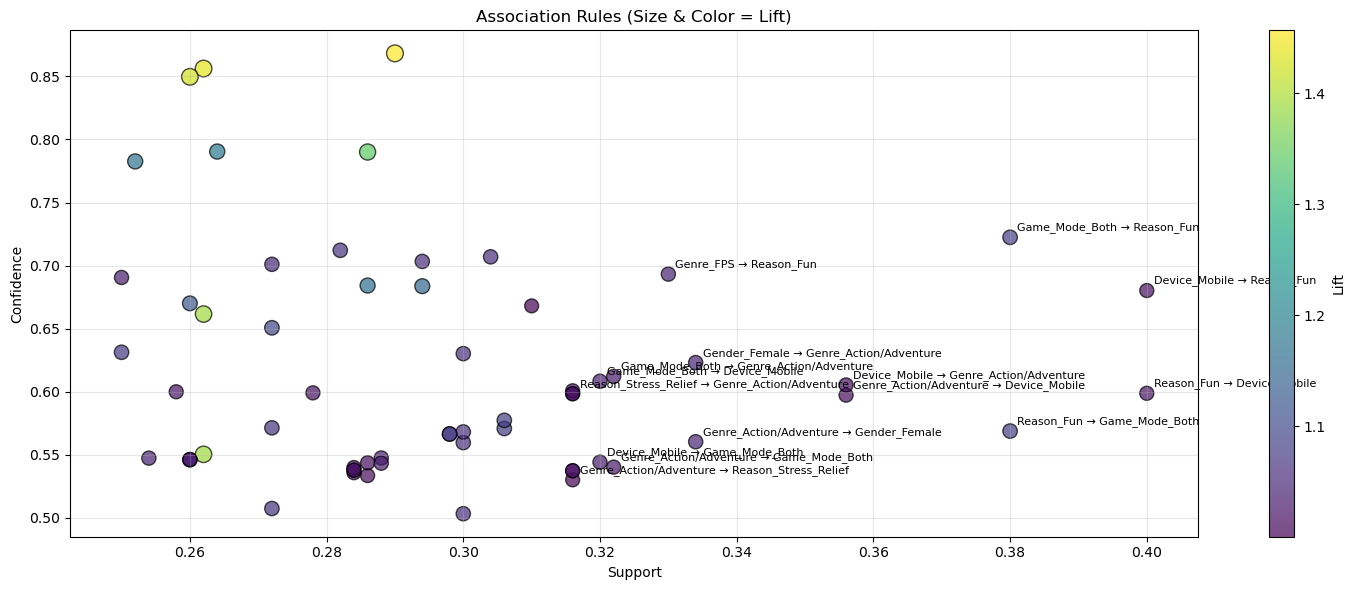

In [11]:
if len(rules) > 0:
    plt.figure(figsize=(15, 6))

    scatter = plt.scatter(
        rules["support"],
        rules["confidence"],
        s=rules["lift"] * 100,
        c=rules["lift"],
        cmap="viridis",
        edgecolors="k",
        alpha=0.7
    )

    # Annotate rules (limit to avoid clutter)
    for _, row in rules.head(15).iterrows():
        antecedents = ", ".join(row["antecedents"])
        consequents = ", ".join(row["consequents"])
        plt.annotate(
            f"{antecedents} → {consequents}",
            (row["support"], row["confidence"]),
            textcoords="offset points",
            xytext=(5, 5),
            fontsize=8
        )

    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.title("Association Rules (Size & Color = Lift)")
    plt.colorbar(scatter, label="Lift")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No association rules found with the given thresholds.")